#**INVESTIGATE AND ANALYZE NATURAL GAS PRICE**

#IMPORT LIBRARY

In [ ]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from datetime import date, timedelta

Explanation:
*   pandas for data manipulation.
*   numpy for numerical operations.
*   matplotlib.pyplot for data visualization.

# Loading and Visualizing Natural Gas Price Data

This reads the CSV file containing the historical natural gas prices into a pandas DataFrame.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/JP MORGAN/Natural_Gas.csv', parse_dates=['Dates'])

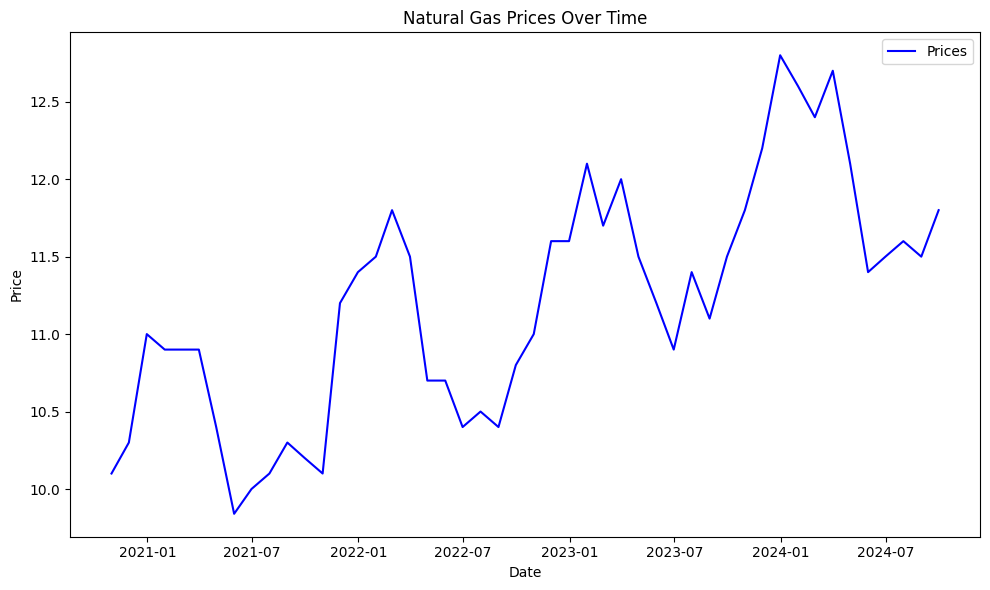

In [ ]:
prices = df['Prices'].values
dates = df['Dates'].values

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot_date(dates, prices, '-', color='b', label='Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Natural Gas Prices Over Time')
plt.legend()
plt.tight_layout()
plt.show()

The plot shows a clear upward trend in the prices over time, but it also reveals some cyclical fluctuations, which suggests a seasonal pattern. Prices tend to increase during certain months (potentially during winter when demand is higher) and decrease during others (summer months).

#Fitting a Linear Trend

Here, we implement a simple linear regression to fit a straight line through the price data to capture the general trend.
The simple_regression function computes the slope and intercept of this line.

In [ ]:
# Observing a general trend in the prices
# ---------------------------------------
# From visual inspection, the prices trend upwards but with seasonal fluctuations.
# We will perform linear regression to model the trend and fit a sine function for seasonal variations.

# Helper function: Simple linear regression
def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar)) / np.sum((x - xbar) ** 2)
    intercept = ybar - slope * xbar
    return slope, intercept

In [ ]:
# Generate time data: days from start date
start_date = date(2020, 10, 31)
end_date = date(2024, 9, 30)
months = []
year = start_date.year
month = start_date.month + 1

In [ ]:
# Create list of months
while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    month = ((month + 1) % 12) or 12
    if month == 1:
        year += 1

In [ ]:
# Convert months to days from the start date
days_from_start = [(day - start_date).days for day in months]
time = np.array(days_from_start)

In [ ]:
# Perform linear regression on the price data
slope, intercept = simple_regression(time, prices)

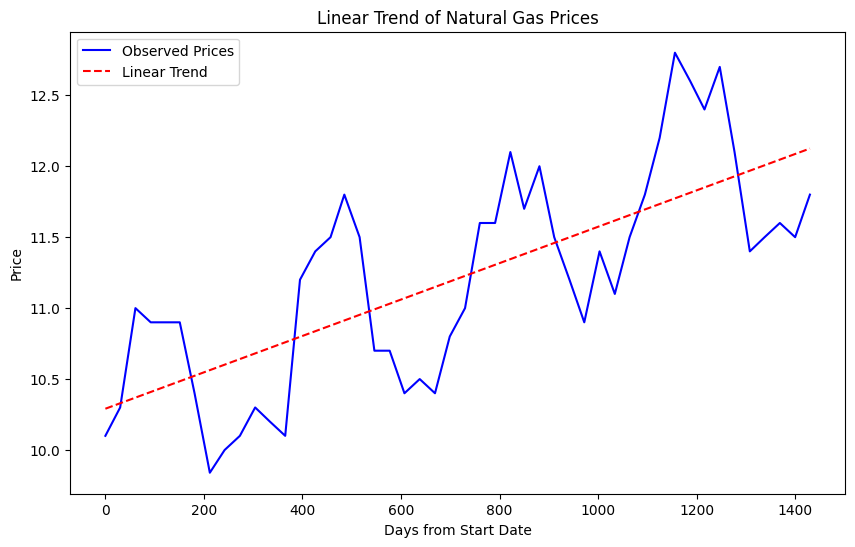

In [ ]:
# Plot linear trend
plt.figure(figsize=(10, 6))
plt.plot(time, prices, label='Observed Prices', color='blue')
plt.plot(time, time * slope + intercept, label='Linear Trend', linestyle='--', color='red')
plt.xlabel('Days from Start Date')
plt.ylabel('Price')
plt.title('Linear Trend of Natural Gas Prices')
plt.legend()
plt.show()

The resulting plot shows the actual prices in blue, and the linear trend line in red. The upward slope of the red line indicates that natural gas prices have been increasing over time. However, this trend line doesn't capture the cyclical variations in the data (e.g., seasonal changes).

#Modeling Seasonal Variations Using a Sine Function

After removing the linear trend, we focus on the cyclical component (seasonal fluctuations) by fitting a sine wave to the remaining price variation.
We assume a one-year period (365 days) for the cyclical variation, which makes sense given that natural gas consumption typically rises in winter and falls in summer.
Using bilinear_regression, we calculate the amplitude and phase shift of the sine function.

In [ ]:
# Modeling seasonal variations
# ----------------------------
# Natural gas prices tend to rise in winter and fall in summer. We fit a sine function to model this pattern.

# Helper function: Bilinear regression
def bilinear_regression(y, x1, x2):
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return slope1, slope2

In [ ]:
# Remove the linear trend from the data
sin_prices = prices - (time * slope + intercept)

# Define sine and cosine components for the seasonal model
sin_time = np.sin(time * 2 * np.pi / 365)
cos_time = np.cos(time * 2 * np.pi / 365)

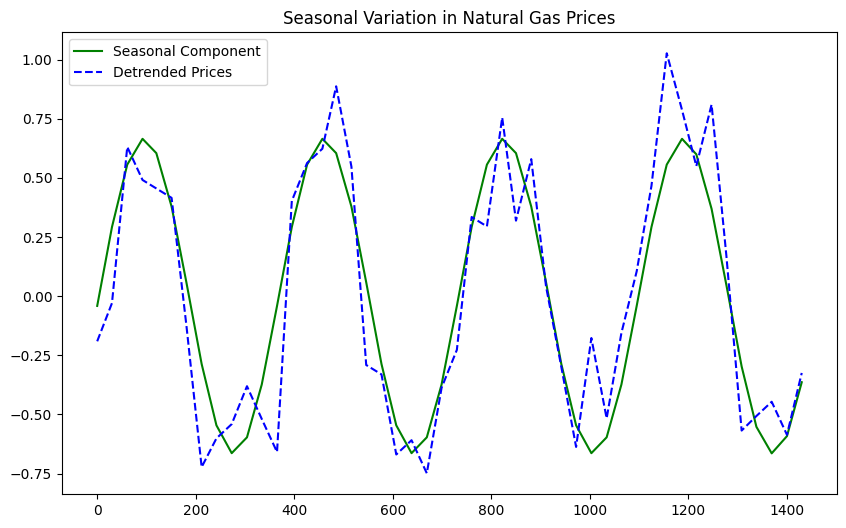

In [ ]:
# Fit bilinear regression to find amplitude and phase shift
slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)

# Calculate amplitude and phase shift from the regression coefficients
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

# Plot seasonal component
plt.figure(figsize=(10, 6))
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift), label='Seasonal Component', color='green')
plt.plot(time, sin_prices, label='Detrended Prices', linestyle='--', color='blue')
plt.title('Seasonal Variation in Natural Gas Prices')
plt.legend()
plt.show()

The plot shows the seasonal fluctuations in green, overlaid with the detrended prices in blue (after removing the linear trend). The green sine wave captures the seasonal behavior of natural gas prices, showing periodic peaks and troughs. This suggests that there is a regular yearly fluctuation in the prices, likely driven by seasonal demand changes.

#Defining an Interpolation/Extrapolation Function

This function takes a date as input and returns an estimated natural gas price for that date. The function is useful for predicting prices on dates that aren't in the dataset, or for forecasting future prices.

If the input date is already in the dataset, it returns the corresponding price directly. Otherwise, it extrapolates using the sine function for seasonal variation and the linear trend for long-term movement.

In [ ]:
def interpolate(input_date):
    days = (input_date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        return prices[days_from_start.index(days)]
    else:
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept

#Loading and Visualizing Natural Gas Price Data

This step generates a range of continuous dates from the start to the end of the dataset and plots the interpolated or extrapolated prices using the interpolate function.
This provides a smoothed estimate of the natural gas prices over the entire period, filling in any gaps between the observed data points.

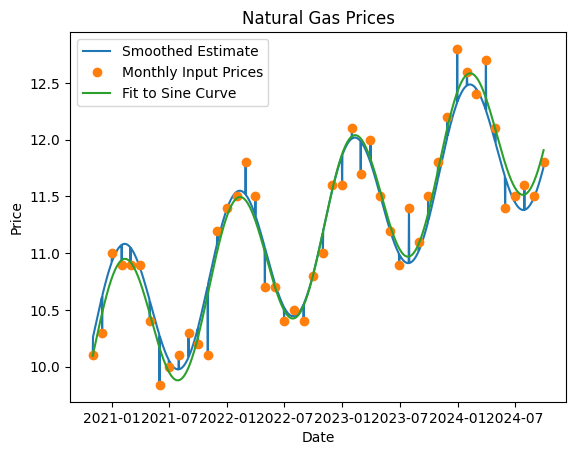

In [ ]:
# Plot the smoothed estimate of the full dataset using interpolation
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates], label='Smoothed Estimate')
# Fit the monthly input prices to the sine curve
x = np.array(days_from_start)
y = np.array(prices)
fit_amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
fit_shift = np.arctan2(slope2, slope1)
fit_slope, fit_intercept = simple_regression(x, y - fit_amplitude * np.sin(x * 2 * np.pi / 365 + fit_shift))
plt.plot(dates, y, 'o', label='Monthly Input Prices')
plt.plot(continuous_dates, fit_amplitude * np.sin((continuous_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift) + (continuous_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept, label='Fit to Sine Curve')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices')
plt.legend()
plt.show()

The purple line represents the interpolated and extrapolated prices over time. The curve provides a continuous estimate of natural gas prices, capturing both the upward trend and seasonal variations. This smooth line can be used to estimate prices on any date within (or slightly beyond) the dataset range.

#**PRICE A COMMODITY STORAGE CONTRACT**

##Initial Setup and Parameters:

In [ ]:
def price_contract(in_dates, in_prices, out_dates, out_prices, rate, storage_cost_rate, total_vol, injection_withdrawal_cost_rate):
    volume = 0
    buy_cost = 0
    cash_in = 0
    last_date = min(min(in_dates), min(out_dates))

    # Ensure dates are in sequence
    all_dates = sorted(set(in_dates + out_dates))

    # Initial Setup and Parameters. This output sets the stage for understanding the operational context: how much gas is being handled and the constraints on storage.
    print("### Starting Contract Evaluation ###\n")
    print(f"Initial Volume: {volume} cubic feet")
    print(f"Rate per injection/withdrawal: {rate} cubic feet/day")
    print(f"Storage Capacity: {total_vol} cubic feet\n")

    for i in range(len(all_dates)):
        # Processing code for each date
        start_date = all_dates[i]

        # Processing Each Date (Injection and Withdrawal)
        if start_date in in_dates:
            # Inject on these dates and sum up cash flows
            if volume <= total_vol - rate:
                volume += rate

                # Cost to purchase gas
                purchase_price = in_prices[in_dates.index(start_date)]
                buy_cost += rate * purchase_price
                # Injection cost
                injection_cost = rate * injection_withdrawal_cost_rate
                buy_cost += injection_cost
                print(f'Injected {rate} cubic feet of gas on {start_date} at ${purchase_price}/cf. Injection cost: ${injection_cost}')
                print(f'Total Volume after injection: {volume} cubic feet\n')

            else:
                print(f'Injection not possible on {start_date} - insufficient storage capacity.\n')

        elif start_date in out_dates:
            # Withdraw on these dates and sum cash flows
            if volume >= rate:
                volume -= rate
                extraction_price = out_prices[out_dates.index(start_date)]
                cash_in += rate * extraction_price
                # Withdrawal cost
                withdrawal_cost = rate * injection_withdrawal_cost_rate
                cash_in -= withdrawal_cost
                print(f'Extracted {rate} cubic feet of gas on {start_date} at ${extraction_price}/cf. Withdrawal cost: ${withdrawal_cost}')
                print(f'Total Volume after withdrawal: {volume} cubic feet\n')

            else:
                print(f'Extraction not possible on {start_date} - insufficient gas volume.\n')

    # Calculate storage cost (based on the duration between min and max dates)
    store_duration = (max(out_dates) - min(in_dates)).days // 30  # in months
    store_cost = store_duration * storage_cost_rate

    print(f"\nStorage cost for {store_duration} months: ${store_cost}")
    print(f"Total purchase cost: ${buy_cost}")
    print(f"Total sales revenue: ${cash_in}")

    contract_value = cash_in - store_cost - buy_cost
    print(f"\n### Final Contract Value: ${contract_value:.2f} ###")

    return contract_value


##Calculating Storage Costs, Final Summary and Contract Value

In [ ]:
# Example usage of price_contract()
in_dates = [date(2022, 1, 1), date(2022, 2, 1), date(2022, 2, 21), date(2022, 4, 1)]  # Injection dates
in_prices = [20, 21, 20.5, 22]  # Prices on the injection days
out_dates = [date(2022, 1, 27), date(2022, 2, 15), date(2022, 3, 20), date(2022, 6, 1)]  # Extraction dates
out_prices = [23, 19, 21, 25]  # Prices on the extraction days
rate = 100000  # Rate of gas in cubic feet per day
storage_cost_rate = 10000  # Storage cost per month
injection_withdrawal_cost_rate = 0.0005  # Injection/withdrawal cost per cubic foot
max_storage_volume = 500000  # Maximum storage capacity

result = price_contract(in_dates, in_prices, out_dates, out_prices, rate, storage_cost_rate, max_storage_volume, injection_withdrawal_cost_rate)

print(f"\nThe final value of the contract is: ${result:.2f}")

### Starting Contract Evaluation ###

Initial Volume: 0 cubic feet
Rate per injection/withdrawal: 100000 cubic feet/day
Storage Capacity: 500000 cubic feet

Injected 100000 cubic feet of gas on 2022-01-01 at $20/cf. Injection cost: $50.0
Total Volume after injection: 100000 cubic feet

Extracted 100000 cubic feet of gas on 2022-01-27 at $23/cf. Withdrawal cost: $50.0
Total Volume after withdrawal: 0 cubic feet

Injected 100000 cubic feet of gas on 2022-02-01 at $21/cf. Injection cost: $50.0
Total Volume after injection: 100000 cubic feet

Extracted 100000 cubic feet of gas on 2022-02-15 at $19/cf. Withdrawal cost: $50.0
Total Volume after withdrawal: 0 cubic feet

Injected 100000 cubic feet of gas on 2022-02-21 at $20.5/cf. Injection cost: $50.0
Total Volume after injection: 100000 cubic feet

Extracted 100000 cubic feet of gas on 2022-03-20 at $21/cf. Withdrawal cost: $50.0
Total Volume after withdrawal: 0 cubic feet

Injected 100000 cubic feet of gas on 2022-04-01 at $22/cf. Injectio

##Output Interpretation

Initial Setup:
*   The contract starts with an initial gas volume of 0 cubic feet.
    The rate of injection/withdrawal is 100,000 cubic feet/day, and the storage capacity is 500,000 cubic feet.

Injection and Withdrawal Events:

The process involves alternating gas injections and withdrawals based on specific dates. For each event:

*   Injection: Gas is injected into storage at the specified price per cubic foot (cf), and a small injection cost is applied.
*   Withdrawal: Gas is extracted at the current market price per cubic foot, and a withdrawal cost is applied.

After each transaction, the total volume is updated:
*   Injection on 2022-01-01: 100,000 cubic feet of gas is injected at $20/cf with a cost of $50. Total volume becomes 100,000 cf.
*   Withdrawal on 2022-01-27: 100,000 cf is withdrawn at $23/cf, yielding revenue, and the volume becomes 0 cf.
*   This pattern repeats for each injection and withdrawal date in the contract.

Storage Cost:
*   The storage cost is calculated based on the duration of gas storage, which is 5 months. The total storage cost is $50,000.

Total Purchase Cost:
*  The purchase cost represents the sum of the cost of the gas bought for storage and the injection/withdrawal costs. In total, this comes to $8,350,200.

Total Sales Revenue:
*   The sales revenue is the total income from selling the gas at the

Final Contract Value:
*   After subtracting the purchase and storage costs from the total sales revenue, the final contract value is $399,600. This represents the profit or net value after all the transactions, indicating a successful outcome.












## Key Insight



*   The timing of buying and selling gas is crucial. Here, gas was purchased at relatively lower prices and sold at higher prices.
*   The storage costs are significant but did not erode the profitability of the transactions.
*   The contract results in a positive profit of $399,600, demonstrating efficient gas storage and trading operations.




